In [1]:
# !pip install lime

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [3]:
# !cp '/content/gdrive/My Drive/court_cases.csv.zip' 'court_cases.csv.zip'
# !unzip court_cases.csv.zip

In [11]:
import nltk
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

True

In [6]:
# !unzip court_cases.csv.zip

In [2]:
import pandas as pd
import numpy as np
import sklearn.ensemble
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.pipeline import make_pipeline
from sklearn.calibration import CalibratedClassifierCV
import lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
import html,nltk
from nltk.corpus import wordnet 
from collections import Counter 
from string import digits
from nltk.stem.snowball import DanishStemmer

def text_cleaning(text, escape_list=[], stop=[]):
    """
    Text cleaning function:
    """
    text=text.lower()
    StopWords = list(set(stopwords.words('dutch')))
    custom_stop = StopWords + stop
    text = html.unescape(text)
    text = re.sub('[^A-Za-z]+', ' ', text)
    text=text.replace('/',' ').replace('?',' ').replace(',',' ').replace('\'',' ')
    tokenz=nltk.word_tokenize(text)
    tokenz=([token for token in tokenz if token not in custom_stop]) 
    # remove_digits = str.maketrans('', '', digits)
#     tokenz=[DanishStemmer().stem(token) if token not in escape_list else token for token in tokenz ]
    return ' '.join(tokenz)

In [4]:
df = pd.read_csv("../data/court_cases_old.csv", lineterminator='\n', index_col=0)
df['Full Text'] = df['process'] + ' ' + df['considerations']
df['Full Text'] = df['Full Text'].apply(text_cleaning)

In [15]:
def do_cross_validation(models,features,labels,CV=5):
    cv_df = pd.DataFrame(index=range(CV * len(models)))
    entries = []
    for model in models:
        model_name = model.__class__.__name__
        accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV,n_jobs=-1)
        for fold_idx, accuracy in enumerate(accuracies):
            entries.append((model_name, fold_idx, accuracy))
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
    plot_cv_result(cv_df)
    return cv_df

def plot_cv_result(cv_df):
    sns.boxplot(x='model_name', y='accuracy', data=cv_df)
    sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
                  size=8, jitter=True, edgecolor="gray", linewidth=2)
    plt.show()



def get_prediction(model,X_train,y_train,X_test,y_test):
    y_pred_trn = model.predict(X_train)
    conf_mat = confusion_matrix(y_train, y_pred_trn)
    print(f'Accuracy for Training Set is  : {accuracy_score(y_train, y_pred_trn)}')
    print(f'Confusion Matrix for Training Set :\n {conf_mat} \n\n Classification Report for Training Set: \n')
    print(classification_report(y_train, y_pred_trn))
    print('--'*50)
    y_pred_tst = model.predict(X_test)
    conf_mat_tst = confusion_matrix(y_test, y_pred_tst)
    print(f'Accuracy for Testing Set is  : {accuracy_score(y_test, y_pred_tst)}')
    print(f'Confusion Matrix for Testing Set :\n {conf_mat_tst} \n\n Classification Report for Testing Set: /n')
    print(classification_report(y_test, y_pred_tst))

# Count Vectorizer / Bag of words Method

(16598, 307281)


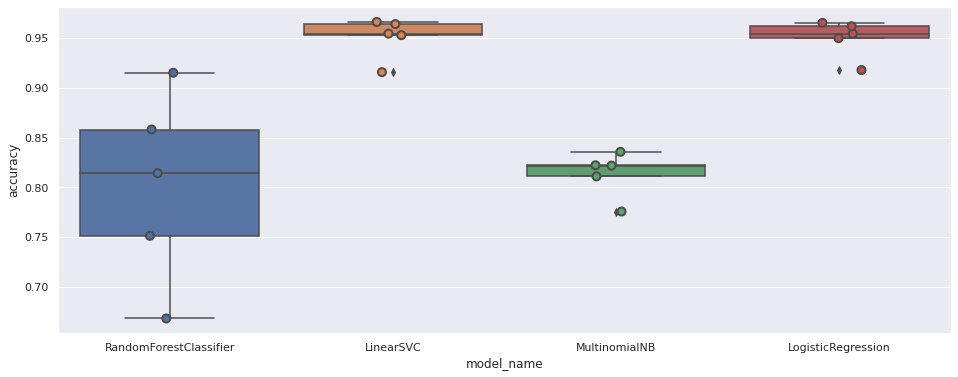

In [125]:
sns.set(rc={'figure.figsize':(16,6)})
countvec = CountVectorizer(min_df=5,ngram_range=(1,2))
features = countvec.fit_transform(df['Full Text'])
labels = df.outcome
print(features.shape)


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

cv_df_countvec = do_cross_validation(models,features,labels,CV=5)


In [126]:
cv_df_countvec.groupby('model_name')['accuracy'].mean().to_frame()

,accuracy
model_name,
LinearSVC,0.950477
LogisticRegression,0.949693
MultinomialNB,0.813413
RandomForestClassifier,0.801550


# TF-IDF Vectorizer Method

(16598, 307281)


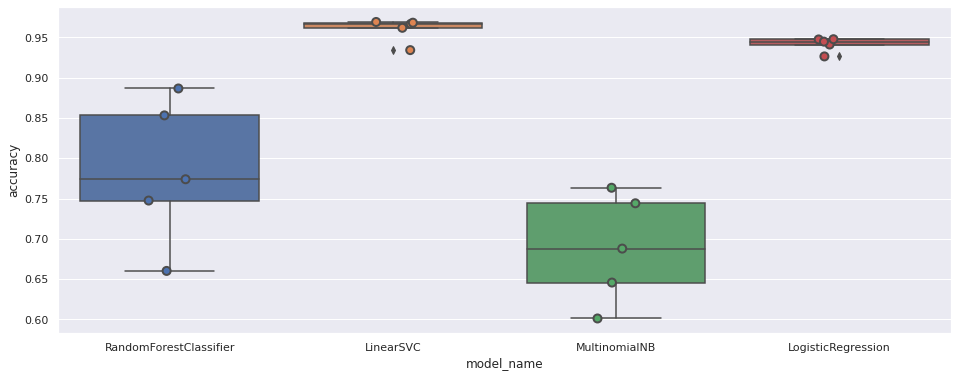

In [127]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2',ngram_range=(1,2))
features = tfidf.fit_transform(df['Full Text'])
labels = df.outcome
print(features.shape)


cv_df_tfidf = do_cross_validation(models,features,labels,CV=5)

In [128]:
cv_df_tfidf.groupby('model_name')['accuracy'].mean().to_frame()

,accuracy
model_name,
LinearSVC,0.960177
LogisticRegression,0.941620
MultinomialNB,0.688525
RandomForestClassifier,0.784377


## Conclusion
With our model evaluation, we can understand that TF-IDF along with SVM works best for our use case.

### Let's look at few metrics now. 

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df['Full Text'], df.outcome, test_size=0.3, random_state=40)

In [17]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2',ngram_range=(1,2))
pipeline = make_pipeline(tfidf,CalibratedClassifierCV(LinearSVC(),method='isotonic'))
pipeline.fit(X_train,y_train)
get_prediction(pipeline,X_train,y_train,X_test,y_test)

Accuracy for Training Set is  : 0.9993974866586331
Confusion Matrix for Training Set :
 [[5218    7]
 [   0 6393]] 

 Classification Report for Training Set: 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5225
           1       1.00      1.00      1.00      6393

   micro avg       1.00      1.00      1.00     11618
   macro avg       1.00      1.00      1.00     11618
weighted avg       1.00      1.00      1.00     11618

----------------------------------------------------------------------------------------------------
Accuracy for Testing Set is  : 0.9795180722891567
Confusion Matrix for Testing Set :
 [[2170   49]
 [  53 2708]] 

 Classification Report for Testing Set: /n
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2219
           1       0.98      0.98      0.98      2761

   micro avg       0.98      0.98      0.98      4980
   macro avg       0.98      0.98   

Pretty  good on all the metrics.

## Now let's try explaining the results

In [18]:
def plot_features_of_explained_model(exp,selected_label):
    imp = pd.DataFrame(exp.as_list(label=selected_label))
    imp.set_index(0,inplace=True)
    imp['color'] = imp[1].apply(lambda x:'Positive' if x>=0 else 'Negative')
    imp[1] = imp[1].apply(abs)

    sns.set(rc={'figure.figsize':(12,12)})
    palette = ["#55a868","#c44e52"]
    ax = sns.barplot(x=imp[1], y=imp.index,hue=imp['color'],palette=palette, dodge=False,hue_order=["Positive", "Negative"]).set_title(f'Feature Importance for Label {selected_label}',fontsize=15)
    plt.show()
    print('Importance of words directly in the text : \n')
    exp.show_in_notebook(text=True,labels=[selected_label])

def explain_model(pipeline,X,y,idx,num_features):
    class_names=list(y.unique())
    explainer = LimeTextExplainer(class_names=class_names)
    exp = explainer.explain_instance(X[idx], pipeline.predict_proba, num_features=num_features, labels=[0,1])
    print('Document id: %d' % idx)
    predicted_class = class_names[pipeline.predict(X[idx:idx+1]).reshape(1,-1)[0,0]]
    class_proba = pipeline.predict_proba(X[idx:idx+1]).max()
    print(f'Predicted class = {predicted_class} ({round(class_proba,4)*100}%)')
    print('Real class: %s' % class_names[y[idx]])
    print(f"Prediction is {'Correct' if (class_names[y[idx]]==class_names[pipeline.predict(X[idx:idx+1]).reshape(1,-1)[0,0]]) else 'Wrong'}.")
    plot_features_of_explained_model(exp=exp,selected_label=y[idx])

Document id: 190
Predicted class = 1 (97.99%)
Real class: 1
Prediction is Correct.


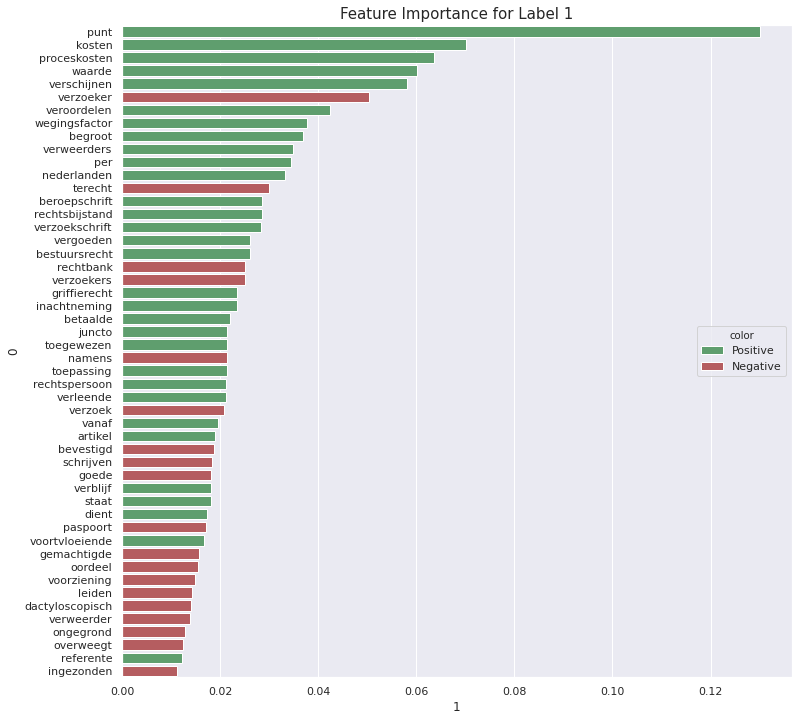

Importance of words directly in the text : 



In [19]:
DOCUMENT_INDEX = 190
explain_model(pipeline=pipeline,X=df['Full Text'],y=df.outcome,idx=DOCUMENT_INDEX,num_features=50)

In [20]:
X,y = df['Full Text'],df.outcome
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2',ngram_range=(1,2))
pipeline = make_pipeline(tfidf,CalibratedClassifierCV(LinearSVC(),method='isotonic'))
pipeline.fit(X,y)

Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth...ty='l2', random_state=None, tol=0.0001,
     verbose=0),
            cv='warn', method='isotonic'))])

## Let's extract the features for all the documents

In [21]:
from tqdm import tqdm

In [50]:
def get_feature_importance_for_full_document(X,y,num_features = 500):
    '''
    Returns Importance as Class 0 Importance
    '''
    class_names=[0, 1]
    explainer = LimeTextExplainer(class_names=class_names)
    full_df = pd.DataFrame()
    for idx in tqdm(range(len(X))):
        exp = explainer.explain_instance(X[idx], pipeline.predict_proba, num_features=num_features, labels=[0,1])
        imp = pd.DataFrame(exp.as_list(label=0),columns=['word','importance'])
        imp['ID'] = idx
        imp['Real Class'] = y[idx]
        imp['Predicted Class'] = pipeline.predict(X[idx:idx+1]).reshape(1,-1)[0,0]
        imp['Predicted Class Probability'] = pipeline.predict_proba(X[idx:idx+1]).max()
        full_df = pd.concat([full_df,imp])
    return full_df

In [55]:
single_processing_op = get_feature_importance_for_full_document(X[:20],y[:20],num_features = 500)

100%|██████████| 20/20 [04:23<00:00, 13.20s/it]


In [54]:
print(f'With single processing, it would take me {int(len(X)/3600*13.20)} hours {int(round(((len(X)/3600*13.20)%1)*60,0))} minutes.')

With single processing, it would take me 60 hours 52 minutes.


# Let's try unleashing Multi-Processing

In [26]:
def get_feature_importance_for_full_document_parallel(X,y,idx,num_features):
    '''
    Returns Importance as Class 0 Importance
    '''
#     print(f'Starting : {idx} {time.time()}')

    explainer = LimeTextExplainer(class_names=[0,1])
    exp = explainer.explain_instance(X, pipeline.predict_proba, num_features=num_features, labels=[0,1])
    imp = pd.DataFrame(exp.as_list(label=0),columns=['word','importance'])
    imp['ID'] = idx
    imp['Real Class'] = y
    imp['Predicted Class'] = pipeline.predict([X]).reshape(1,-1)[0,0]
    imp['Predicted Class Probability'] = pipeline.predict_proba([X]).max()
    return imp

In [61]:
import multiprocessing
import time

start = time.time()

with multiprocessing.Pool(processes=100) as pool:
    results = pool.starmap(get_feature_importance_for_full_document_parallel, [(X[idx],y[idx],idx,500) for idx in range(len(X))])
full_df = pd.concat(results)
end = time.time()

total_time = end - start
# print('Time :',total_time)
print(f'With multiprocessing the job was finished in {int(total_time/3600)} hours {int(round(((total_time/3600)%1)*60,0))} minutes.')

With multiprocessing the job was finished in 3 hours 49 minutes.


In [35]:
# full_df.to_csv('Feature Importance By words.csv.gz',index=False,compression='gzip')

In [ ]:
# full_df = pd.read_csv('Feature Importance By words.csv.gz',compression='gzip')

In [82]:
def plot_features_from_full_data(imp,top_n = 50,label=0):
#     imp = pd.DataFrame(exp.as_list(label=selected_label))
#     imp.set_index('word',inplace=True)
    imp['color'] = imp['importance'].apply(lambda x:'Positive' if x>=0 else 'Negative')
    imp['importance'] = imp['importance'].apply(abs)
    imp = imp.sort_values('importance',ascending=False)[:top_n]
    sns.set(rc={'figure.figsize':(12,12)})
    palette = ["#55a868","#c44e52"]
    ax = sns.barplot(x=imp['importance'], y=imp.index,hue=imp['color'],palette=palette, dodge=False,hue_order=["Positive", "Negative"]).set_title(f'Feature Importance for Entire Data (Class {label})',fontsize=15)
    plt.show()

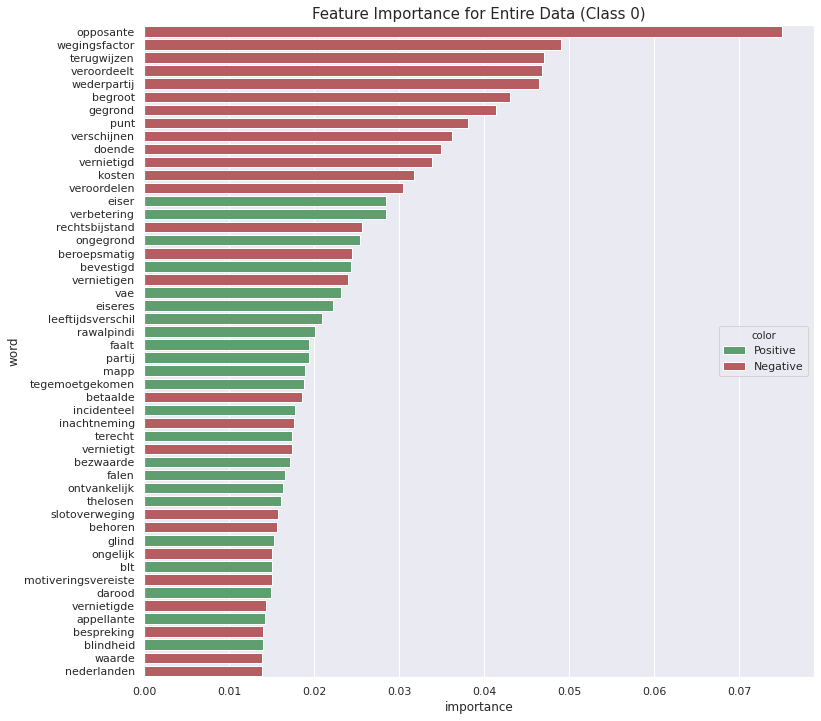

In [84]:
class_0_features = full_df[(full_df['Real Class']==full_df['Predicted Class']) & (full_df['Real Class']==0)].groupby('word')['importance'].mean().to_frame()
plot_features_from_full_data(class_0_features,top_n=50,label=0)

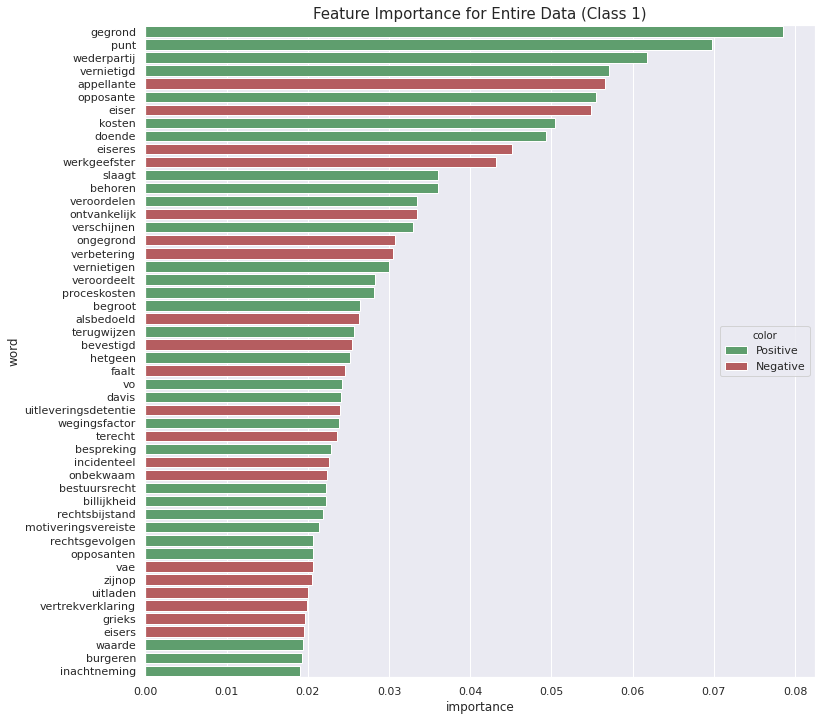

In [85]:
class_1_features = full_df[(full_df['Real Class']==full_df['Predicted Class']) & (full_df['Real Class']==1)].groupby('word')['importance'].mean().to_frame()
class_1_features['importance'] = class_1_features['importance']*-1
plot_features_from_full_data(class_1_features,top_n=50,label=1)